# Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Dataset

In [ ]:
drive_path = '/content/drive/MyDrive/dataset'

In [ ]:
data_generator = ImageDataGenerator()
ds = data_generator.flow_from_directory(directory=drive_path,
                                         target_size=(224, 224),
                                         batch_size=32,
                                         class_mode='categorical')

Found 2194 images belonging to 5 classes.


In [ ]:
class_names = list(ds.class_indices.keys())
print(class_names)

['Blossom-end-rottation', 'Cracking', 'Healthy', 'Spliting', 'Sun-scaled']


# Preprocessing

Processing folder: Blossom-end-rottation
Processing folder: Cracking
Processing folder: Healthy
Processing folder: Spliting
Processing folder: Sun-scaled
Loaded 2198 images from 5 classes.


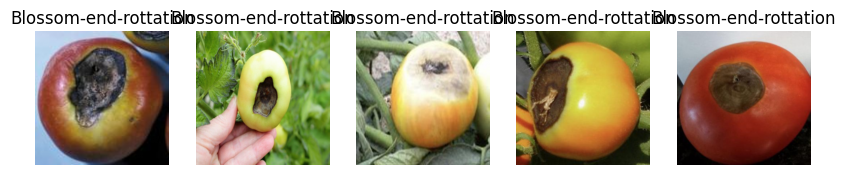

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess the image: open, resize, and convert to array.
    """
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    return image_array

def load_and_preprocess_images(directory):
    """
    Load and preprocess images from directory and subdirectories.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    num_classes = len(class_names)
    class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        subdir_path = os.path.join(directory, class_name)
        if os.path.isdir(subdir_path):
            print(f"Processing folder: {class_name}")
            for file in os.listdir(subdir_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    file_path = os.path.join(subdir_path, file)
                    try:
                        image_array = preprocess_image(file_path)
                        images.append(image_array)
                        labels.append(class_dict[class_name])
                    except Exception as e:
                        print(f"Error processing image {file_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

# Loading and preprocessing images, as well as labeling them by folder name
images, labels, class_names = load_and_preprocess_images(drive_path)

print(f"Loaded {len(images)} images from {len(class_names)} classes.")

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.show()

# Print names of five classes
print("Names of five classes:")
for i in range(5):
    print(class_names[i])


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% data for validation
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Uses 'categorical' for multi-class classification
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Uses 'categorical' for multi-class classification
    subset='validation'
)

Found 1757 images belonging to 5 classes.
Found 437 images belonging to 5 classes.


# Model Building

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Menggunakan jumlah kelas sesuai dengan dataset
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

# Pelatihan dan Evaluasi Model

In [ ]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

Epoch 1/25
55/55 [==============================] - 177s 3s/step - loss: 1.4135 - accuracy: 0.3688 - val_loss: 1.4093 - val_accuracy: 0.4110
Epoch 2/25
55/55 [==============================] - 172s 3s/step - loss: 1.2865 - accuracy: 0.4511 - val_loss: 1.4033 - val_accuracy: 0.4658
Epoch 3/25
55/55 [==============================] - 175s 3s/step - loss: 1.1448 - accuracy: 0.5403 - val_loss: 1.2456 - val_accuracy: 0.4429
Epoch 4/25
55/55 [==============================] - 186s 3s/step - loss: 1.0244 - accuracy: 0.5892 - val_loss: 1.3919 - val_accuracy: 0.4863
Epoch 5/25
55/55 [==============================] - 174s 3s/step - loss: 0.9200 - accuracy: 0.6352 - val_loss: 1.2572 - val_accuracy: 0.4749
Epoch 6/25
55/55 [==============================] - 171s 3s/step - loss: 0.8574 - accuracy: 0.6699 - val_loss: 1.1701 - val_accuracy: 0.5023
Epoch 7/25
55/55 [==============================] - 184s 3s/step - loss: 0.7382 - accuracy: 0.7188 - val_loss: 1.2549 - val_accuracy: 0.5297
Epoch 8/25
55

# Evaluasi dan Visualisasi

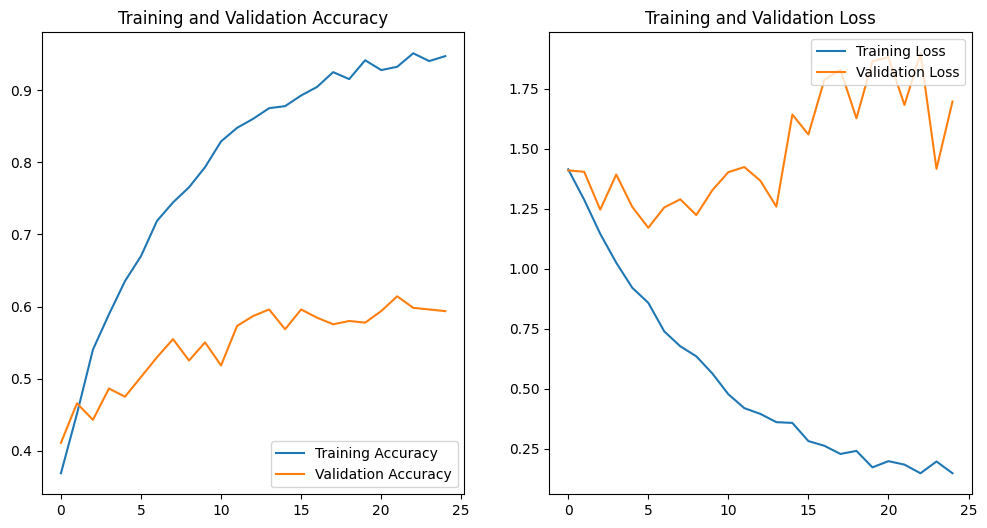

In [ ]:
# Evaluation and Visualization of Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

14/14 [==============================] - 15s 1s/step - loss: 1.7492 - accuracy: 0.5913
Validation Accuracy: 59.13%


# MobileNetV3Large model


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import numpy as np
import os

In [ ]:
# Build MobileNetV3Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')  # Change the number of output units to 5
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

12683000/12683000 [==============================] - 1s 0us/step


In [16]:
# Train the model
epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10
55/55 [==============================] - 1052s 19s/step - loss: 0.4745 - accuracy: 0.8327 - val_loss: 1.7113 - val_accuracy: 0.2723
Epoch 2/10
55/55 [==============================] - 120s 2s/step - loss: 0.1110 - accuracy: 0.9636 - val_loss: 1.7996 - val_accuracy: 0.2769
Epoch 3/10
55/55 [==============================] - 116s 2s/step - loss: 0.0631 - accuracy: 0.9852 - val_loss: 2.2706 - val_accuracy: 0.0778
Epoch 4/10
55/55 [==============================] - 118s 2s/step - loss: 0.0473 - accuracy: 0.9841 - val_loss: 1.7270 - val_accuracy: 0.2723
Epoch 5/10
55/55 [==============================] - 122s 2s/step - loss: 0.0417 - accuracy: 0.9898 - val_loss: 5.8215 - val_accuracy: 0.0778
Epoch 6/10
55/55 [==============================] - 120s 2s/step - loss: 0.0729 - accuracy: 0.9806 - val_loss: 1.6931 - val_accuracy: 0.2723
Epoch 7/10
55/55 [==============================] - 119s 2s/step - loss: 0.0880 - accuracy: 0.9715 - val_loss: 2.7858 - val_accuracy: 0.2723
Epoch 8/10


In [17]:
# Evaluate the model
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

14/14 [==============================] - 11s 705ms/step


In [18]:
# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Cotrnfusion Matrix:\n", conf_matrix)

Cotrnfusion Matrix:
 [[  0 119   0   0   0]
 [  0 105   0   0   0]
 [  0  34   0   0   0]
 [  0  91   0   0   0]
 [  0  88   0   0   0]]


In [19]:
# Calculate and print overall metrics
accuracy = accuracy_score(y_true, y_pred)
print("Overall Accuracy:", accuracy)

Overall Accuracy: 0.2402745995423341


In [20]:
# Calculate precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.unique(y_true))

# Print metrics for each class
for i, class_name in enumerate(validation_generator.class_indices):
    print(f"\nMetrics for Class '{class_name}':")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1-Score:", f1[i])



Metrics for Class 'Blossom-end-rottation':
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Metrics for Class 'Cracking':
Precision: 0.2402745995423341
Recall: 1.0
F1-Score: 0.3874538745387454

Metrics for Class 'Healthy':
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Metrics for Class 'Spliting':
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Metrics for Class 'Sun-scaled':
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Specify all unique classes in your data
unique_classes = sorted(set(y_true + y_pred))

# Nama kelas yang ingin ditampilkan dalam laporan klasifikasi
class_number = '5'

# Menghasilkan laporan klasifikasi
class_report = classification_report(y_true, y_pred, labels=unique_classes, target_names=[class_number], zero_division=1)

# Menampilkan laporan klasifikasi
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           5       0.24      1.00      0.39       105

   micro avg       0.24      0.33      0.28       318
   macro avg       0.85      0.40      0.28       318
weighted avg       0.75      0.33      0.13       318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 5, does not match size of target_names, 1
  warnings.warn(


#EfficientNetB0 model

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Input

base_model = EfficientNetB0(weights=None, include_top=False, input_tensor=Input(shape=(224, 224, 3)))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')
])


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
# Train the model
epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10
55/55 [==============================] - 252s 4s/step - loss: 1.6653 - accuracy: 0.3113 - val_loss: 1.5517 - val_accuracy: 0.2723
Epoch 2/10
55/55 [==============================] - 219s 4s/step - loss: 1.3733 - accuracy: 0.4109 - val_loss: 1.6743 - val_accuracy: 0.2723
Epoch 3/10
55/55 [==============================] - 221s 4s/step - loss: 1.2206 - accuracy: 0.4838 - val_loss: 1.6586 - val_accuracy: 0.2723
Epoch 4/10
55/55 [==============================] - 219s 4s/step - loss: 1.1225 - accuracy: 0.5526 - val_loss: 1.8210 - val_accuracy: 0.2723
Epoch 5/10
55/55 [==============================] - 225s 4s/step - loss: 1.0542 - accuracy: 0.6005 - val_loss: 1.7451 - val_accuracy: 0.2128
Epoch 6/10
55/55 [==============================] - 219s 4s/step - loss: 0.9191 - accuracy: 0.6477 - val_loss: 1.8868 - val_accuracy: 0.2014
Epoch 7/10
55/55 [==============================] - 220s 4s/step - loss: 0.8413 - accuracy: 0.6836 - val_loss: 1.6003 - val_accuracy: 0.3227
Epoch 8/10
55

In [26]:
import numpy as np
# Evaluate the model
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

14/14 [==============================] - 17s 1s/step


In [28]:
# Calculate and print overall metrics
accuracy = accuracy_score(y_true, y_pred)
print("Overall Accuracy:", accuracy)

Overall Accuracy: 0.2288329519450801
